In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import math
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt

In [2]:
def get_stock_price_daily(ticker):
    df = yf.download(ticker, start='2021-01-01', threads= False)
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
    return df


def get_stock_price_weekly(ticker):
    df = yf.download(ticker, start='2021-01-01', interval = "1wk", threads= False)
    df['Date'] = pd.to_datetime(df.index)
    df['Date'] = df['Date'].apply(mpl_dates.date2num)
    df = df.loc[:,['Date', 'Open', 'High', 'Low', 'Close']]
    return df

In [3]:
symbol = '0166.KL'
df_weekly = get_stock_price_weekly(symbol)
df_daily = get_stock_price_daily(symbol)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df_weekly

,Date,Open,High,Low,Close
Date,,,,,
2020-12-28,18624.0,2.76,2.76,2.76,2.76
2021-01-04,18631.0,2.76,2.78,2.55,2.62
2021-01-11,18638.0,2.60,2.94,2.57,2.91
2021-01-18,18645.0,2.91,3.23,2.89,3.23
2021-01-25,18652.0,3.19,3.51,3.11,3.40
...,...,...,...,...,...
2022-02-07,19030.0,3.25,3.43,3.23,3.28
2022-02-14,19037.0,3.25,3.35,3.19,3.20
2022-02-21,19044.0,3.20,3.22,3.03,3.16


In [5]:
# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
    ave =  np.mean(df['High'] - df['Low'])    
    return np.sum([abs(value-level)<ave for _,level in levels])==0


def plot_all(levels, df):    
    fig, ax = plt.subplots(figsize=(16, 9))   
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)    
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)    
    for level in levels:        
        plt.hlines(level[1], xmin = df['Date'][level[0]], xmax = max(df['Date']), colors='black', linestyle='--')    
    fig.show()


def detect_support_resistance(df):
    levels = []
    max_list = []
    min_list = []
    
    for i in range(5, len(df)-5):
        high_range = df['High'][i-5:i+4]
        current_max = high_range.max()
        if current_max not in max_list:
            max_list = []
        max_list.append(current_max)
        
        if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
            levels.append((high_range.idxmax(), current_max))
      
        low_range = df['Low'][i-5:i+5]
        current_min = low_range.min()
        if current_min not in min_list:
            min_list = []
        min_list.append(current_min)
        
        if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
            levels.append((low_range.idxmin(), current_min))
    return levels

In [6]:
level_weekly = detect_support_resistance(df_weekly)

<ipython-input-5-7151ae1eb260>:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


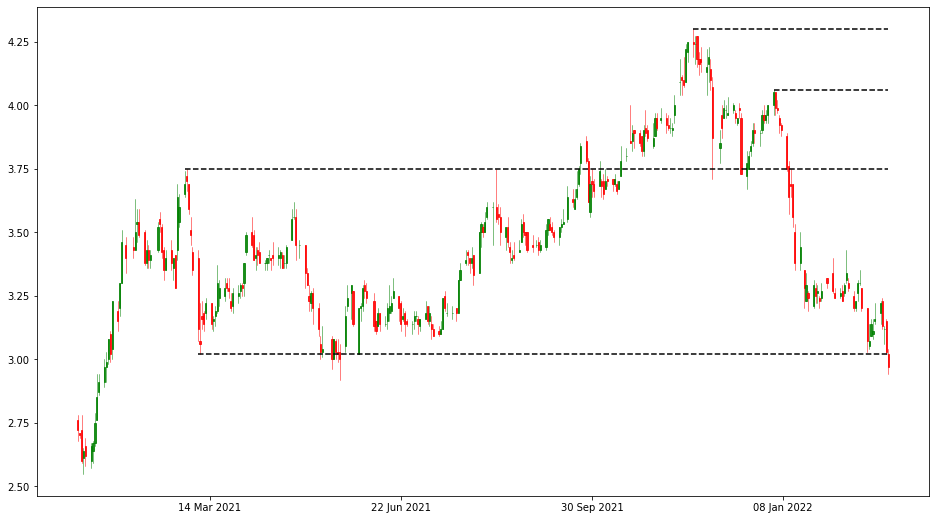

In [7]:
plot_all(level_weekly, df_daily)

## Breakdown and Breakup analysis

In [8]:
#Define breakout and breakdown 
def breakdown_stock(levels, previous, today):
    for _, level in levels:
        cond1 = (previous['Open'] >= level) 
        cond2 = (today['Open'] <= level) and (today['Close'] < level)
    return (cond1 and cond2)


def breakout_stock(levels, previous, today):
    for _, level in levels:
        cond1 = (previous['Open'] <= level) 
        cond2 = (today['Open'] >= level) and (today['Close'] > level)
    return (cond1 and cond2)

In [10]:
breakout_stock_list = []
breakdown_stock_list = []

In [11]:
from bs4 import BeautifulSoup
import pandas as pd
import re
import requests
import yfinance as yf

def get_stock_code_list_bursa():
    url = "https://www.malaysiastock.biz/Stock-Screener.aspx"
    response = requests.get(url, headers={'User-Agent':'test'})
    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find(id = "MainContent2_tbAllStock")
    stock_list = table.find_all('a')
    return [stock_code.get('href')[-4:] for stock_code in stock_list]


def get_stock_name_list_bursa():
    url = "https://www.malaysiastock.biz/Stock-Screener.aspx"
    response = requests.get(url, headers={'User-Agent':'test'})
    soup = BeautifulSoup(response.content, "html.parser")
    table = soup.find(id = "MainContent2_tbAllStock")
    stock_list = table.find_all('a')
    return [stock_code for stock_code in stock_list]

In [12]:
stock_list = get_stock_code_list_bursa()

In [13]:
stock_list[0]

'0012'

In [14]:
for ticker in stock_list:
    try:
        df_daily = get_stock_price_daily(ticker+'.KL')
        df_weekly = get_stock_price_weekly(ticker+'.KL')
        
        levels = detect_support_resistance(df_weekly)
        
        if breakout_stock(levels[-5:], df_daily.iloc[-2], df_daily.iloc[-1]):
            breakout_stock_list.append(ticker)
        
        elif breakdown_stock(levels[-5:], df_daily.iloc[-2], df_daily.iloc[-1]):
            breakdown_stock_list.append(ticker)
            
    except Exception as e:
        print(e) 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 00EA.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 00EA.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 c

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 24EA.KL: No 

[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3001.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3002.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3002.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed downloa

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3019.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3019.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 c

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3037.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3037.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3036.KL: No data found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- 3036.KL: No data found, symbol may be delisted
single positional indexer is out-of-bounds
[*********************100%***********************]  1 of 1 completed
[****************

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
local variable 'cond1' referenced before assignment
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
local variable 'cond1' referenced before assignment
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
local variable 'cond1' referenced before assignment
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
local variable 'cond1' referenced before assignment
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
local variable 'cond1' referenced before assignment


In [15]:
breakout_stock_list

['5229',
 '2143',
 '5614',
 '7183',
 '4235',
 '5983',
 '0112',
 '7219',
 '0153',
 '5681',
 '2542',
 '5205',
 '5111']

In [16]:
breakdown_stock_list

['7054',
 '5190',
 '5738',
 '7202',
 '1619',
 '7149',
 '7047',
 '0074',
 '5182',
 '7668',
 '0143',
 '3794',
 '1643',
 '0108',
 '5065',
 '4634',
 '4596',
 '5218',
 '4375',
 '4405',
 '9741',
 '6963',
 '0066',
 '4677',
 '0222']

In [77]:
symbol = '0225.KL'

test_df_daily = get_stock_price_daily(symbol)
test_df_weekly = get_stock_price_weekly(symbol)

l = detect_support_resistance(test_df_weekly)
l

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[(Timestamp('2021-02-15 00:00:00'), 0.6000000238418579),
 (Timestamp('2021-03-01 00:00:00'), 0.44999998807907104),
 (Timestamp('2021-04-26 00:00:00'), 0.5600000023841858),
 (Timestamp('2021-06-14 00:00:00'), 0.5099999904632568),
 (Timestamp('2021-08-02 00:00:00'), 0.38999998569488525)]

In [69]:
def plot_all_test(levels, df):    
    fig, ax = plt.subplots(figsize=(16, 9))   
    candlestick_ohlc(ax,df.values,width=0.6, colorup='green', colordown='red', alpha=0.8)    
    date_format = mpl_dates.DateFormatter('%d %b %Y')
    ax.xaxis.set_major_formatter(date_format)    
    for level in levels:        
        plt.hlines(level[1], xmin = [level[0]], xmax = max(df['Date']), colors='black', linestyle='--')    
    fig.show()

<ipython-input-69-8f0437d95974>:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


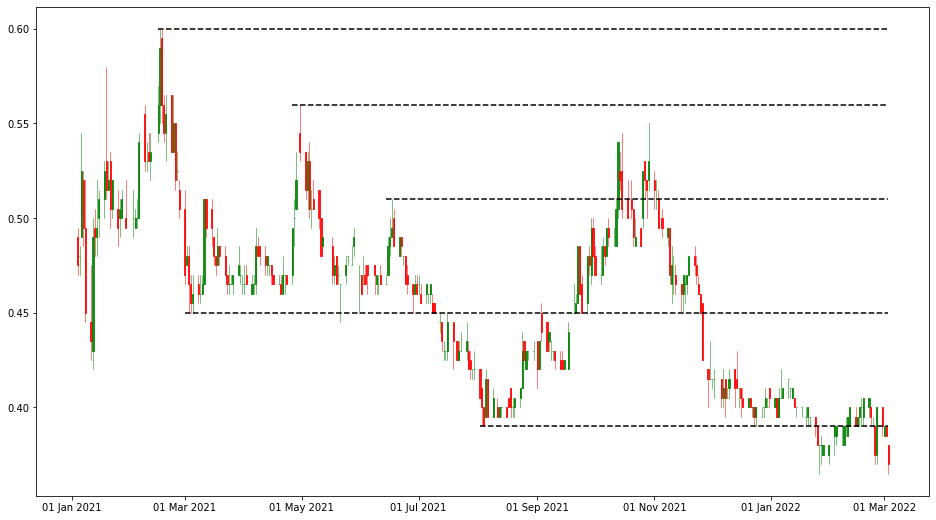

In [78]:
plot_all_test(l, test_df_daily)